In [1]:
from pathlib import Path
import sys
import os
import pypsa


def find_repo_root(max_up=6):
    p = Path.cwd().resolve()
    for _ in range(max_up):
        if (p / 'README.md').exists() or (p / '.git').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return Path.cwd().resolve()

repo_root = find_repo_root()
src_path = repo_root / 'src/'
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))
print(f"Using src path: {src_path}")
print(f"Repository root: {repo_root}")

import pypsa_simplified as ps

src_path = repo_root / 'scripts/'
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

import geometry as geom

def ifjoin(n: pypsa.Network) -> bool:
    """Helper function to conditionally join network buses."""
    return "[join]" in str(n.name)

def iffloat(n: pypsa.Network) -> bool:
    """Helper function to conditionally join network buses."""
    return "[float]" in str(n.name)

import network_clust as netclust

# T,T ; T,F ; F,T ; F,F

JOIN = True
FLOAT_ = True

Using src path: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/src
Repository root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model


In [2]:
network_path = repo_root / "data" / "networks" / "base" / f"sEEN{"_join" if JOIN else ""}{"_f" if FLOAT_ else ""}.nc"
n = pypsa.Network(network_path)

INFO:pypsa.network.io:Imported network 'Simplified European Electricity Network [join] [float]' has buses, carriers, lines, links, loads, transformers


In [3]:
# Check current network structure
print("=" * 70)
print("NETWORK BEFORE SIMPLIFICATION")
print("=" * 70)
print(f"\nBuses: {len(n.buses)}")
print(f"  Voltage levels: {sorted(n.buses.v_nom.unique())}")
print(f"  Countries: {sorted(n.buses.country.unique())}")
print(f"\nLines: {len(n.lines)}")
print(f"Links: {len(n.links)}")
print(f"Transformers: {len(n.transformers)}")
print(f"Loads: {len(n.loads)}")
print(f"Generators: {len(n.generators)}")

# Check for converters (HVDC with empty carrier)
if len(n.links) > 0:
    converters = n.links[n.links.carrier == ""]
    print(f"\nHVDC Converters: {len(converters)}")
    if len(converters) > 0:
        print(f"  DC buses: {len(n.buses[n.buses.carrier == 'DC'])}")

NETWORK BEFORE SIMPLIFICATION

Buses: 6359
  Voltage levels: [np.float64(150.0), np.float64(200.0), np.float64(220.0), np.float64(225.0), np.float64(236.0), np.float64(250.0), np.float64(270.0), np.float64(275.0), np.float64(300.0), np.float64(320.0), np.float64(330.0), np.float64(350.0), np.float64(380.0), np.float64(400.0), np.float64(420.0), np.float64(450.0), np.float64(500.0), np.float64(515.0), np.float64(525.0), np.float64(600.0), np.float64(750.0)]
  Countries: ['', 'AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']

Lines: 8385
Links: 103
Transformers: 812
Loads: 6258
Generators: 0

HVDC Converters: 66
  DC buses: 133


In [4]:
# Reload the network and modules after fixing the stub removal
import importlib
importlib.reload(netclust)

# Reload network
n = pypsa.Network(network_path)

print("Reloaded network - starting fresh simplification...")

INFO:pypsa.network.io:Imported network 'Simplified European Electricity Network [join] [float]' has buses, carriers, lines, links, loads, transformers


Reloaded network - starting fresh simplification...


# Network Simplification and Clustering

According to PyPSA-EUR workflow, we need to:
1. **Simplify network** - Convert all voltage levels to 380kV
2. **Remove HVDC converters** - Collapse DC buses to AC
3. **Remove stubs** - Clean dead-ends from the network
4. **Cluster network** - Reduce to N buses using k-means

The documentation states that clustering cannot be done reliably with multiple voltage levels and transformers, so simplification is mandatory first.

In [5]:
# Step 1: Simplify network to 380kV voltage level
print("Step 1: Simplifying network to 380kV...")
n_old = n.copy()
n_simplified, trafo_map = netclust.simplify_network_to_380(n)

print(f"\nAfter simplification:")
print(f"  Buses: {len(n_simplified.buses)} vs {len(n_old.buses)}")
print(f"  Voltage levels: {sorted(n_simplified.buses.v_nom.unique())}")
print(f"  Lines: {len(n_simplified.lines)} vs {len(n_old.lines)}")
print(f"  Transformers: {len(n_simplified.transformers)} (should be 0)")
print(f"  Loads: {len(n_simplified.loads)} vs {len(n_old.loads)}")

INFO:network_clust:Simplifying network to 380kV voltage level


Step 1: Simplifying network to 380kV...

After simplification:
  Buses: 5566 vs 6359
  Voltage levels: [np.float64(380.0)]
  Lines: 8385 vs 8385
  Transformers: 0 (should be 0)
  Loads: 6258 vs 6258


In [6]:
# Step 2: Remove HVDC converters
print("Step 2: Removing HVDC converters...")
n_no_conv, converter_map = netclust.remove_converters(n_simplified)

print(f"\nAfter removing converters:")
print(f"  Buses: {len(n_no_conv.buses)}")
print(f"  DC buses: {len(n_no_conv.buses[n_no_conv.buses.carrier == 'DC'])}")
print(f"  Links: {len(n_no_conv.links)}")
converters_left = n_no_conv.links[n_no_conv.links.carrier == ""]
print(f"  HVDC Converters: {len(converters_left)} (should be 0)")

INFO:network_clust:Removing HVDC converters
INFO:network_clust:Removed 66 converters and 64 DC buses


Step 2: Removing HVDC converters...

After removing converters:
  Buses: 5502
  DC buses: 69
  Links: 37
  HVDC Converters: 0 (should be 0)


In [7]:
# Step 3: Remove stub buses (dead-ends)
print("Step 3: Removing stub buses...")
n_clean, stub_map = netclust.remove_stubs(
    n_no_conv,
    matching_attrs=['country']  # Keep country boundaries intact
)

print(f"\nAfter removing stubs:")
print(f"  Buses: {len(n_clean.buses)}")
print(f"  Lines: {len(n_clean.lines)}")
print(f"  Links: {len(n_clean.links)}")
print(f"  Loads: {len(n_clean.loads)}")

INFO:network_clust:Removing stub buses from network


Step 3: Removing stub buses...


INFO:network_clust:Removed 1548 stub buses



After removing stubs:
  Buses: 3954
  Lines: 5485
  Links: 28
  Loads: 6258


## 4. Pre-Clustering Connectivity Fixes

Before clustering, we need to ensure the network is fully connected:
1. **Connect link-only buses**: HVDC link endpoints that have no AC lines need virtual connections to the nearest grid bus
2. **Make links bidirectional**: Set `p_min_pu = -1` so power can flow in both directions

In [8]:
# =============================================================================
# STEP 4A: CONNECT LINK-ONLY BUSES TO GRID
# =============================================================================
# Some buses only have HVDC links but no AC lines - these need virtual 
# connections to the nearest grid bus for proper power flow

print("Step 4A: Connecting link-only buses to grid...")
link_result = netclust.connect_link_buses_to_grid(n_clean)

print(f"\nResult:")
print(f"  Link-only buses found: {link_result['link_only_buses']}")
print(f"  Virtual links added: {len(link_result['virtual_links_added'])}")

if link_result['virtual_links_added']:
    print(f"\nVirtual connections:")
    for link_name, bus, nearest_bus, cap in link_result['virtual_links_added'][:5]:
        print(f"  {link_name}: {nearest_bus} <-> {bus} (capacity: {cap:.0f} MW)")
    if len(link_result['virtual_links_added']) > 5:
        print(f"  ... and {len(link_result['virtual_links_added']) - 5} more")

INFO:network_clust:============================================================
INFO:network_clust:CONNECTING LINK-ONLY BUSES TO MAIN GRID (using Links)
INFO:network_clust:============================================================
INFO:network_clust:Buses in lines: 3891
INFO:network_clust:Buses in links: 51
INFO:network_clust:Buses with links but no lines: 51


Step 4A: Connecting link-only buses to grid...


INFO:network_clust:Added 51 virtual links to connect link-only buses
INFO:network_clust:  way/26619335 Converter: way/26619335-400 <-> way/26619335 (975 MW)
INFO:network_clust:  way/136594238 Converter: way/100253768-380 <-> way/136594238 (450 MW)
INFO:network_clust:  way/1262324052 Converter: way/34968224-330 <-> way/1262324052 (525 MW)
INFO:network_clust:  way/140248148 Converter: way/140248148-400 <-> way/140248148 (750 MW)
INFO:network_clust:  way/940919943 Converter: way/32318130-220 <-> way/940919943 (900 MW)
INFO:network_clust:  ... and 46 more



Result:
  Link-only buses found: 51
  Virtual links added: 51

Virtual connections:
  way/26619335 Converter: way/26619335-400 <-> way/26619335 (capacity: 975 MW)
  way/136594238 Converter: way/100253768-380 <-> way/136594238 (capacity: 450 MW)
  way/1262324052 Converter: way/34968224-330 <-> way/1262324052 (capacity: 525 MW)
  way/140248148 Converter: way/140248148-400 <-> way/140248148 (capacity: 750 MW)
  way/940919943 Converter: way/32318130-220 <-> way/940919943 (capacity: 900 MW)
  ... and 46 more


In [9]:
# =============================================================================
# STEP 4B: MAKE LINKS BIDIRECTIONAL
# =============================================================================
# DC links default to unidirectional (p_min_pu=0). Set to bidirectional 
# so power can flow in both directions.

print("Step 4B: Making links bidirectional...")
n_bidirectional = netclust.make_links_bidirectional(n_clean)

print(f"\nResult:")
print(f"  Links made bidirectional: {n_bidirectional}")
print(f"  Total links: {len(n_clean.links)}")

# Verify
if len(n_clean.links) > 0:
    unidirectional = (n_clean.links.p_min_pu >= 0).sum()
    print(f"  Remaining unidirectional: {unidirectional} (should be 0)")

INFO:network_clust:Made 28 links bidirectional (p_min_pu = -1.0)


Step 4B: Making links bidirectional...

Result:
  Links made bidirectional: 28
  Total links: 79
  Remaining unidirectional: 0 (should be 0)


In [10]:
# =============================================================================
# VERIFY NETWORK CONNECTIVITY
# =============================================================================
import networkx as nx

print("="*70)
print("VERIFYING NETWORK CONNECTIVITY BEFORE CLUSTERING")
print("="*70)

# Build graph from lines and links
G = nx.Graph()
G.add_nodes_from(n_clean.buses.index)

for idx, line in n_clean.lines.iterrows():
    G.add_edge(line.bus0, line.bus1, component='line', name=idx)

for idx, link in n_clean.links.iterrows():
    G.add_edge(link.bus0, link.bus1, component='link', name=idx)

# Check connectivity
components = list(nx.connected_components(G))
print(f"\nConnected components: {len(components)}")

if len(components) > 1:
    print("\n⚠️  WARNING: Network has multiple disconnected components!")
    for i, comp in enumerate(sorted(components, key=len, reverse=True)):
        countries = n_clean.buses.loc[list(comp), 'country'].unique()
        print(f"  Component {i+1}: {len(comp)} buses, countries: {list(countries)}")
else:
    print("✅ Network is fully connected - ready for clustering!")

VERIFYING NETWORK CONNECTIVITY BEFORE CLUSTERING

Connected components: 14

⚠️  WARNING: Network has multiple disconnected components!
  Component 1: 3939 buses, countries: ['NL', 'IT', 'PL', 'DK', 'HR', 'FR', 'PT', 'SK', 'CH', 'CZ', 'FI', 'ES', 'DE', 'GB', 'NO', 'HU', 'RO', 'GR', 'SE', 'BE', 'IE', 'SI', 'EE', 'BG', 'AT', 'LT', 'LV', 'LU']
  Component 2: 3 buses, countries: ['ES']
  Component 3: 1 buses, countries: ['RO']
  Component 4: 1 buses, countries: ['RO']
  Component 5: 1 buses, countries: ['HR']
  Component 6: 1 buses, countries: ['IT']
  Component 7: 1 buses, countries: ['GB']
  Component 8: 1 buses, countries: ['SE']
  Component 9: 1 buses, countries: ['ES']
  Component 10: 1 buses, countries: ['GB']
  Component 11: 1 buses, countries: ['SE']
  Component 12: 1 buses, countries: ['DK']
  Component 13: 1 buses, countries: ['GB']
  Component 14: 1 buses, countries: ['IT']


In [11]:
# =============================================================================
# STEP 4C: CONNECT ISOLATED COMPONENTS TO MAIN GRID
# =============================================================================
# Some small isolated components exist - connect them to the nearest bus
# in the main network component
import numpy as np

print("="*70)
print("STEP 4C: CONNECTING ISOLATED COMPONENTS TO MAIN GRID")
print("="*70)

# Rebuild graph to find components
G = nx.Graph()
G.add_nodes_from(n_clean.buses.index)
for idx, line in n_clean.lines.iterrows():
    G.add_edge(line.bus0, line.bus1)
for idx, link in n_clean.links.iterrows():
    G.add_edge(link.bus0, link.bus1)

components = list(nx.connected_components(G))
components_sorted = sorted(components, key=len, reverse=True)

main_component = components_sorted[0]
isolated_buses = []
for comp in components_sorted[1:]:
    isolated_buses.extend(list(comp))

print(f"Main component: {len(main_component)} buses")
print(f"Isolated buses to connect: {len(isolated_buses)}")

# Get coordinates for main component buses
main_buses = list(main_component)
main_coords = n_clean.buses.loc[main_buses, ['x', 'y']].values

# Connect each isolated bus to nearest main component bus
virtual_connections = []
for iso_bus in isolated_buses:
    iso_coord = n_clean.buses.loc[iso_bus, ['x', 'y']].values
    
    # Calculate distances
    distances = np.sqrt((main_coords[:, 0] - iso_coord[0])**2 + 
                       (main_coords[:, 1] - iso_coord[1])**2)
    
    nearest_idx = distances.argmin()
    nearest_bus = main_buses[nearest_idx]
    distance_deg = distances[nearest_idx]
    distance_km = distance_deg * 111  # Rough conversion
    
    # Add virtual line
    line_name = f"virtual_isolated_conn_{iso_bus}"
    if line_name not in n_clean.lines.index:
        x = 0.0001 * max(distance_km, 1)
        r = 0.00003 * max(distance_km, 1)
        
        n_clean.add(
            "Line",
            line_name,
            bus0=iso_bus,
            bus1=nearest_bus,
            s_nom=2000,  # High capacity
            x=max(x, 0.0001),
            r=max(r, 0.0001),
            length=max(distance_km, 1),
            carrier='AC',
        )
        virtual_connections.append((iso_bus, nearest_bus, distance_km))
        
print(f"\nAdded {len(virtual_connections)} virtual connections for isolated buses")

# Show connections
for iso, main, dist in virtual_connections[:10]:
    iso_country = n_clean.buses.loc[iso, 'country']
    main_country = n_clean.buses.loc[main, 'country']
    print(f"  {iso} ({iso_country}) -> {main} ({main_country}): {dist:.1f} km")
if len(virtual_connections) > 10:
    print(f"  ... and {len(virtual_connections) - 10} more")

# Verify connectivity again
G2 = nx.Graph()
G2.add_nodes_from(n_clean.buses.index)
for idx, line in n_clean.lines.iterrows():
    G2.add_edge(line.bus0, line.bus1)
for idx, link in n_clean.links.iterrows():
    G2.add_edge(link.bus0, link.bus1)

components2 = list(nx.connected_components(G2))
print(f"\n✅ After fix: {len(components2)} connected component(s)")

STEP 4C: CONNECTING ISOLATED COMPONENTS TO MAIN GRID
Main component: 3939 buses
Isolated buses to connect: 15

Added 15 virtual connections for isolated buses
  way/139280545-220 (ES) -> way/165580300-400 (ES): 209.0 km
  way/139280769-220 (ES) -> way/165580300-400 (ES): 215.8 km
  way/81409681-220 (ES) -> way/165580300-400 (ES): 202.0 km
  RO45-220 (RO) -> way/199657972-400 (RO): 69.4 km
  way/108198777-220 (RO) -> way/232685942-220 (BG): 73.9 km
  way/113757307-220 (HR) -> way/89823918-400 (HR): 33.8 km
  way/1158716725 (IT) -> way/82767145-380 (IT): 173.3 km
  way/1262971878 (GB) -> way/166703766-400 (GB): 105.1 km
  way/1265541077 (SE) -> SE55-400 (SE): 42.3 km
  way/131323212 (ES) -> ES257-400 (ES): 132.8 km
  ... and 5 more

✅ After fix: 1 connected component(s)


In [12]:
n.determine_network_topology()

PyPSA Network 'Simplified European Electricity Network [join] [float]'
----------------------------------------------------------------------
Components:
 - Bus: 5502
 - Carrier: 15
 - Line: 8385
 - Link: 37
 - Load: 6258
 - SubNetwork: 78
Snapshots: 35064

In [ ]:
def convert_links_to_lines_and_dc_to_ac(n: pypsa.Network) -> dict:
    """
    Convert all links to AC lines and all DC buses to AC buses.
    
    This creates a pure AC network by:
    1. Converting all DC buses to AC (carrier='AC')
    2. Converting all links to equivalent AC lines
    
    Parameters
    ----------
    n : pypsa.Network
        Network to modify (in-place)
        
    Returns
    -------
    dict
        Summary with:
        - 'dc_buses_converted': number of DC buses converted to AC
        - 'links_converted': number of links converted to lines
        - 'new_lines': list of new line names created
    """
    print("="*70)
    print("CONVERTING LINKS TO LINES AND DC BUSES TO AC")
    print("="*70)
    
    # Count initial state
    initial_dc_buses = (n.buses.carrier == 'DC').sum()
    initial_links = len(n.links)
    
    print(f"\nInitial state:")
    print(f"  DC buses: {initial_dc_buses}")
    print(f"  Links: {initial_links}")
    print(f"  Lines: {len(n.lines)}")
    
    # Step 1: Convert all DC buses to AC
    if initial_dc_buses > 0:
        n.buses.loc[n.buses.carrier == 'DC', 'carrier'] = 'AC'
        print(f"\n✅ Converted {initial_dc_buses} DC buses to AC")
    
    # Step 2: Convert all links to lines
    new_lines = []
    if initial_links > 0:
        for link_name, link in n.links.iterrows():
            # Create equivalent line
            line_name = f"line_{link_name}"
            
            # Calculate line parameters from link
            # Links have p_nom (MW), we need s_nom (MVA) for lines
            s_nom = link.p_nom
            
            # Use link efficiency to calculate resistance (losses)
            # efficiency = exp(-r * length / v_nom^2 * s_nom)
            # For simplicity, use small r for high efficiency
            efficiency = link.get('efficiency', 1.0)
            if efficiency < 1.0:
                # Approximate: r ≈ -ln(efficiency) * v_nom^2 / (length * s_nom)
                # For typical HVDC, use small resistance
                r = (1 - efficiency) * 0.01
            else:
                r = 0.00001  # Very small resistance for lossless
            
            # Reactance: typical for HVDC equivalent, use small value
            x = 0.0001
            
            # Calculate length from bus coordinates
            bus0_coord = n.buses.loc[link.bus0, ['x', 'y']].values
            bus1_coord = n.buses.loc[link.bus1, ['x', 'y']].values
            
            # Euclidean distance in degrees
            distance_deg = np.sqrt((bus0_coord[0] - bus1_coord[0])**2 + 
                                   (bus0_coord[1] - bus1_coord[1])**2)
            
            # Convert to km (rough approximation: 1 degree ≈ 111 km)
            length = max(distance_deg * 111, 1)  # Minimum 1 km to avoid zero length
            
            # Add the line
            try:
                n.add(
                    "Line",
                    line_name,
                    type='Al/St 240/40 4-bundle 380.0',
                    bus0=link.bus0,
                    bus1=link.bus1,
                    s_nom=s_nom,
                    r=r,
                    x=x,
                    length=length,
                    carrier='AC',
                )
                new_lines.append(line_name)
            except Exception as e:
                print(f"  Warning: Could not add line {line_name}: {e}")
        
        # Remove all links
        n.remove("Link", n.links.index)
        
        print(f"\n✅ Converted {initial_links} links to {len(new_lines)} lines")
    
    # Final state
    print(f"\nFinal state:")
    print(f"  DC buses: {(n.buses.carrier == 'DC').sum()} (should be 0)")
    print(f"  Links: {len(n.links)} (should be 0)")
    print(f"  Lines: {len(n.lines)}")
    print("="*70)
    
    return {
        'dc_buses_converted': initial_dc_buses,
        'links_converted': initial_links,
        'new_lines': new_lines
    }


# Apply the conversion
result = convert_links_to_lines_and_dc_to_ac(n_clean)

print(f"\n✅ Network is now pure AC:")
print(f"   {result['dc_buses_converted']} DC buses → AC")
print(f"   {result['links_converted']} links → lines")
print(f"   Total lines: {len(n_clean.lines)}")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (814849454.py, line 81)

In [ ]:
# =============================================================================
# SAVE SIMPLIFIED NETWORK
# =============================================================================
n_clean.name = n.name + " [simple]"

join = ifjoin(n)
float_ = iffloat(n)

simplified_path = repo_root / "data" / "networks" / "base" / f"SC+_sEEN{'_join' if join else ''}{'_f' if float_ else ''}.nc"

n_clean.export_to_netcdf(simplified_path)
print(f"\n✅ Saved simplified network to: {simplified_path}")
print(f"   Buses: {len(n_clean.buses)}")
print(f"   Lines: {len(n_clean.lines)}")
print(f"   Links: {len(n_clean.links)} (all bidirectional)")

INFO:pypsa.network.io:Exported network 'Simplified European Electricity Network [join] [float] [simple]' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/base/SC+_sEEN_join_f.nc contains: sub_networks, carriers, loads, lines, buses



✅ Saved simplified network to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/data/networks/base/SC+_sEEN_join_f.nc
   Buses: 3954
   Lines: 5579
   Links: 0 (all bidirectional)


SIMPLIFIED NETWORK VISUALIZATION

Saved figure to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/figures/network_03_simplified.png


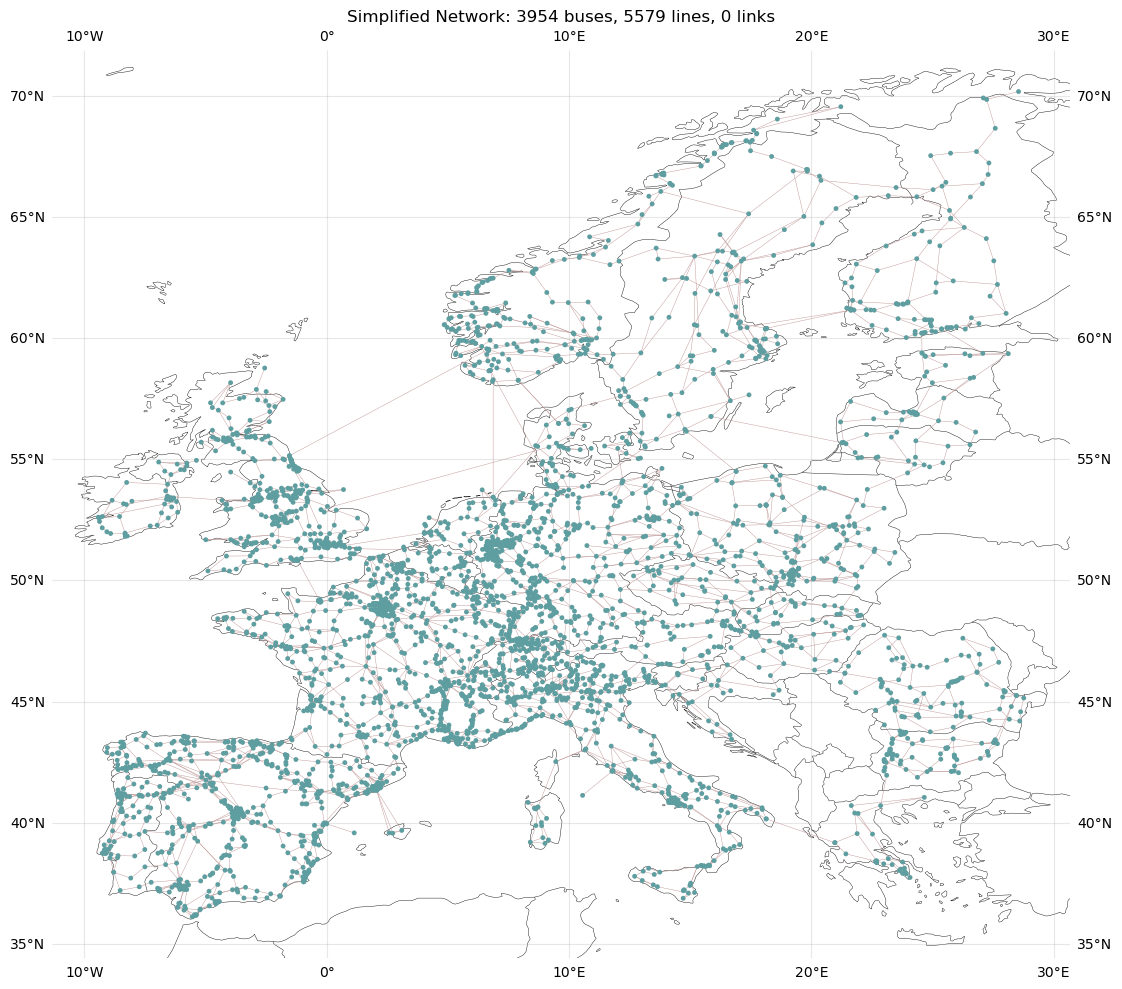

In [ ]:
# =============================================================================
# VISUALIZE FINAL SIMPLIFIED NETWORK
# =============================================================================
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

print("="*70)
print("SIMPLIFIED NETWORK VISUALIZATION")
print("="*70)

fig = plt.figure(figsize=(14, 10))
proj = ccrs.PlateCarree()
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Plot the network
n_clean.plot(
    ax=ax,
    bus_sizes=0.01,
    line_widths=0.3,
    link_widths=0.8,
    link_colors='red',
    margin=0.05,
    title=f"Simplified Network: {len(n_clean.buses)} buses, {len(n_clean.lines)} lines, {len(n_clean.links)} links"
)

# Add gridlines
ax.gridlines(draw_labels=True, alpha=0.3)

plt.tight_layout()

# Save figure
fig_path = repo_root / 'results' / 'figures' / 'network_03_simplified.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
print(f"\nSaved figure to: {fig_path}")

plt.show()

## Summary of Simplification

The network has been successfully simplified following PyPSA-EUR methodology:

✅ **Step 1 - Voltage Simplification**: Reduced from 21 voltage levels → 1 level (380kV)
- Removed transformers
- Collapsed multi-voltage buses

✅ **Step 2 - HVDC Converter Removal**: Collapsed DC buses to AC equivalents
- Removed HVDC converters
- Removed DC buses

✅ **Step 3 - Stub Removal**: Cleaned dead-end buses
- Removed isolated stub buses
- Preserved loads through redistribution

✅ **Step 4 - Connectivity Fixes**: Ensured network is fully connected
- Connected link-only buses to nearest grid bus via virtual lines
- Made all DC links bidirectional (p_min_pu = -1)
- Verified single connected component

The network is now ready for clustering!

## Next Steps: Complete PyPSA-EUR Workflow

According to the PyPSA-EUR documentation, the complete workflow is:

### Already Completed ✅
1. **Base network** - Network topology with buses, lines, links
2. **Add loads** - Time series demand data added to all buses  
3. **Simplify network** - Reduced to 380kV, removed converters and stubs

### Next Steps (in order):

4. **Cluster network** (Optional but recommended)
   - Reduce computational complexity by clustering to N buses
   - Common values: 37, 128, 256, 512 buses
   - Uses k-means or hierarchical clustering
   - Preserves country boundaries and load patterns

5. **Build powerplants** 
   - Add conventional generators (coal, gas, nuclear, etc.)
   - Use powerplantmatching database or custom data
   - Assign to nearest bus in clustered network

6. **Build renewable profiles**
   - Calculate wind and solar capacity factors from weather data (atlite)
   - Determine installable potentials per region
   - Add extendable renewable generators with time series

7. **Build hydro profiles**
   - Add hydro storage units with inflow time series
   - Model reservoir capacity and constraints

8. **Add electricity** (final assembly)
   - Combine all components into complete network
   - Add storage units (batteries, hydrogen)
   - Set up extendable capacities

9. **Prepare network**
   - Set CO2 emission limits
   - Configure solver options
   - Add constraints (N-1 security, etc.)

10. **Solve optimization**
    - Run capacity expansion or operational optimization
    - Analyze results

### Recommendation

**You should cluster the network first** before adding generators. This is because:
- Clustering significantly reduces problem size (3,954 → ~100-500 buses)
- Generators are then assigned to clustered buses (more efficient)
- PyPSA-EUR workflow does clustering before adding generators
- Much faster computation time for subsequent steps